# Jira Ticket Age

In [2]:
# SPDX-License-Identifier: Apache-2.0
# Licensed to the Ed-Fi Alliance under one or more agreements.
# The Ed-Fi Alliance licenses this file to you under the Apache License, Version 2.0.
# See the LICENSE and NOTICES files in the project root for more information.

from dataclasses import dataclass
import logging
import sys
from typing import List, Tuple, Optional

from jira import JIRA

from edfi_tech_metrics.settings import load_from_env

conf = load_from_env()

# https://jira.readthedocs.io/
conf.info(f"Connecting to {conf.jira_base_url}")
jira = JIRA(conf.jira_base_url, token_auth=conf.jira_token)

Connecting to https://tracker.ed-fi.org


In [5]:
PAGE_SIZE = 100

@dataclass
class IssuePage:
    issue_list: List[Tuple[str, Optional[str]]]
    last_key: str


def get_page_of_issues(project_key: str, begin: str) -> IssuePage:
    jql = f"project={project_key} AND key {begin} AND resolution = Unresolved order by created asc"
    conf.debug(jql)
    issues = jira.search_issues(jql, maxResults=PAGE_SIZE)

    last = None
    if len(issues) == PAGE_SIZE:
        last = issues[-1].key
    
    return IssuePage([(project_key, i.fields.created) for i in issues], last)


def get_project(project: str) -> List[List[str]]:
    data = []
    
    begin = f">= {project}-1"

    # "Do...While" type loop to get all pages of data.
    while True:
        page = get_page_of_issues(project, begin)

        data.extend(page.issue_list)

        if page.last_key is None:
            break
            
        # Next request to get_issues needs to look for items _after_ the last one received
        begin = f"> {page.last_key}"

    return data

In [21]:
import pandas as pd
from datetime import datetime
import tzlocal

now = datetime.now(tzlocal.get_localzone())

projects = ["DMS", "ADMINAPI"]

data = []
for p in projects:
    data.extend(get_project(p))

df = pd.DataFrame(columns=["project", "created"], data=data)

df["created"] = pd.to_datetime(df["created"], utc=True)
df["age"] = (now - df["created"]).dt.components.days

project=DMS and key >= DMS-1 order by created asc
project=ADMINAPI and key >= ADMINAPI-1 order by created asc
project=ADMINAPI and key > ADMINAPI-105 order by created asc
project=ADMINAPI and key > ADMINAPI-205 order by created asc
project=ADMINAPI and key > ADMINAPI-307 order by created asc
project=ADMINAPI and key > ADMINAPI-410 order by created asc
project=ADMINAPI and key > ADMINAPI-510 order by created asc
project=ADMINAPI and key > ADMINAPI-611 order by created asc
project=ADMINAPI and key > ADMINAPI-714 order by created asc
project=ADMINAPI and key > ADMINAPI-815 order by created asc
project=ADMINAPI and key > ADMINAPI-915 order by created asc


,age
project,
ADMINAPI,237.933747
DMS,26.477273


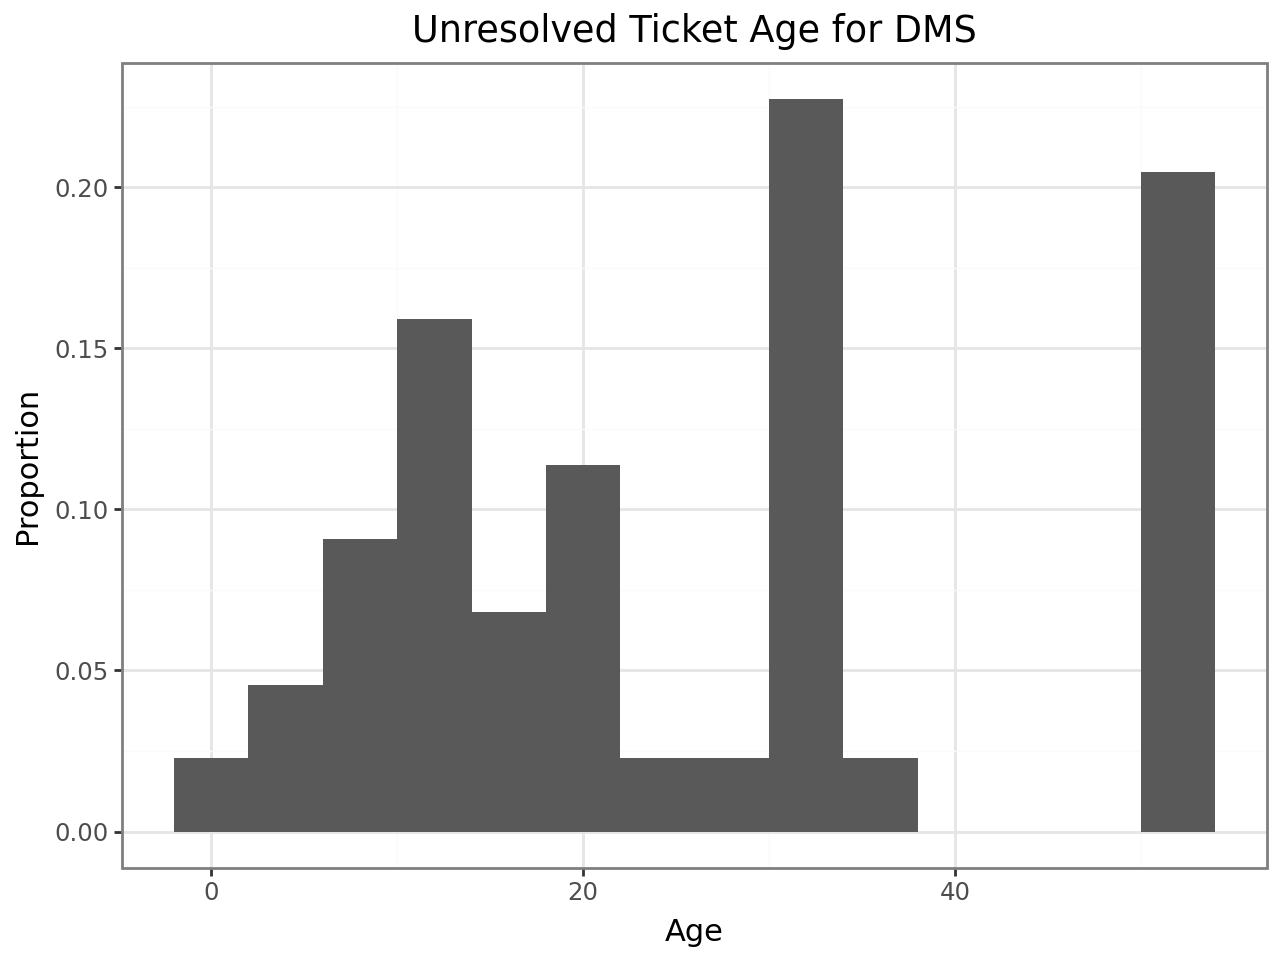

,count,mean,std,min,25%,50%,75%,max
DMS,44.0,26.477273,16.401203,1.0,11.0,23.0,32.0,53.0


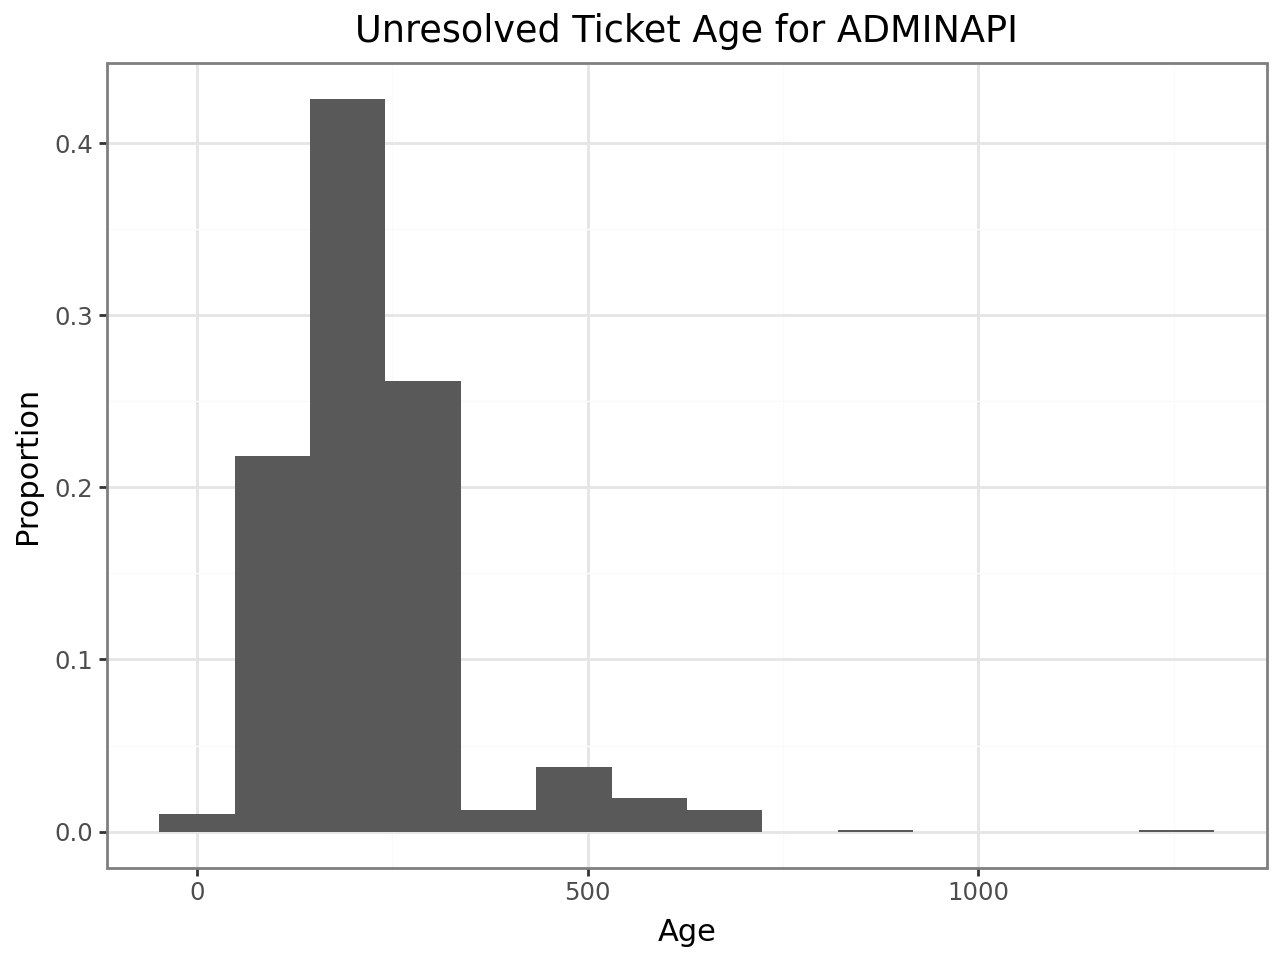

,count,mean,std,min,25%,50%,75%,max
ADMINAPI,966.0,237.933747,122.775796,15.0,186.0,222.0,306.0,1269.0


In [60]:
from plotnine import aes, geom_histogram, ggplot, after_stat, theme_bw, labs

stats = []

for project in projects:
    filtered = df[df["project"] == project]

    p = (
        ggplot(filtered, aes(x="age", y=after_stat("width*density"))) +
            geom_histogram(bins=14) +
             labs(
                title= f"Unresolved Ticket Age for {project}",
                x="Age",
                y="Proportion"
            ) +
            theme_bw()
    )
    p.show()


    t = filtered[["Age"]].rename(columns={"Age": project})
    t = t.describe().transpose()
    stats.append(t)

    display(t)

In [65]:
stats_df = pd.concat(stats)

today = datetime.today().strftime('%Y-%m-%d')

stats_df["date"] = today
stats_df.reset_index(inplace=True)

stats_df.to_csv(f"./data/ticket-age-{today}.csv")

stats_df

,index,count,mean,std,min,25%,50%,75%,max,date
0,DMS,44.0,26.477273,16.401203,1.0,11.0,23.0,32.0,53.0,2024-03-09
1,ADMINAPI,966.0,237.933747,122.775796,15.0,186.0,222.0,306.0,1269.0,2024-03-09
